In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import json
from pandas import json_normalize

import datetime as dt

import geopandas as gpd
from geopandas import GeoDataFrame

from shapely.geometry import Point

from openaq import OpenAQ

from pyathena import connect

from dotenv import load_dotenv 
import os 

https://www.codecademy.com/article/python-environment-variables

In [2]:
load_dotenv()

api_key = os.getenv("openaq_key") 
debug = os.getenv("DEBUG", "False") 

In [3]:
la_bounds_gdf = gpd.read_file("../../Data/Inputs/Boundary_Shapefile/la_mainland.geojson")

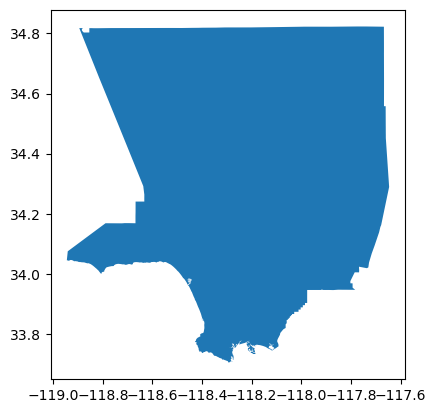

In [4]:
la_bounds_gdf.plot();

In [5]:
# The bounding box for LA County
bbox = [-118.944703049253,
        33.7046743723892,
        -117.646385981235,
        34.823304156602]

In [6]:
client = OpenAQ(api_key)
response = client.locations.list(
    bbox=bbox,
    limit=1000
)
data = response.dict()
stations_df = json_normalize(data['results'])

In [7]:
stations_df.head(3)

,id,name,locality,timezone,is_mobile,is_monitor,instruments,sensors,bounds,distance,...,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_first.local,datetime_last.utc,datetime_last.local,datetime_first,datetime_last
0,847,South Long Beach,None,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1502, 'name': 'pm25 µg/m³', 'parameter...","[-118.175278, 33.792221, -118.175278, 33.792221]",None,...,119,AirNow,33.792221,-118.175278,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,2022-05-05T22:00:00Z,2022-05-05T15:00:00-07:00,NaN,NaN
1,1019,Pasadena,None,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1837, 'name': 'o3 ppm', 'parameter': {...","[-118.1081, 34.0833, -118.1081, 34.0833]",None,...,119,AirNow,34.083300,-118.108100,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,2016-11-09T21:00:00Z,2016-11-09T13:00:00-08:00,NaN,NaN
2,1036,Pico Rivera,None,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1866, 'name': 'o3 ppm', 'parameter': {...","[-118.059196, 34.0131, -118.059196, 34.0131]",None,...,119,AirNow,34.013100,-118.059196,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,2016-11-09T21:00:00Z,2016-11-09T13:00:00-08:00,NaN,NaN


In [8]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     435 non-null    int64  
 1   name                   435 non-null    object 
 2   locality               39 non-null     object 
 3   timezone               435 non-null    object 
 4   is_mobile              435 non-null    bool   
 5   is_monitor             435 non-null    bool   
 6   instruments            435 non-null    object 
 7   sensors                435 non-null    object 
 8   bounds                 435 non-null    object 
 9   distance               0 non-null      object 
 10  country.id             435 non-null    int64  
 11  country.code           435 non-null    object 
 12  country.name           435 non-null    object 
 13  owner.id               435 non-null    int64  
 14  owner.name             435 non-null    object 
 15  provid

I will convert this to a geodataframe using the lat and long columns:

https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html

In [9]:
stations_gdf = gpd.GeoDataFrame(
    stations_df, geometry=gpd.points_from_xy(stations_df['coordinates.longitude'], stations_df['coordinates.latitude']), crs="EPSG:4326"
)

In [10]:
stations_gdf.to_file("../../Data/Outputs/stations_gdf.geojson", driver="GeoJSON")

There are several columns which have large amounts of null entries and don't add much to the dataset, so I will drop them. I will also drop the local datetime features and only use the `UTC` ones:

In [11]:
stations_gdf.drop(columns=['locality','distance','datetime_first','datetime_last','datetime_first.local', 'datetime_first.local'],inplace=True)

In [12]:
dt_cols = stations_gdf.columns[17:19]

In [13]:
for col in dt_cols:
    stations_gdf[col] = pd.to_datetime(stations_gdf[col])

In [14]:
stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     435 non-null    int64              
 1   name                   435 non-null    object             
 2   timezone               435 non-null    object             
 3   is_mobile              435 non-null    bool               
 4   is_monitor             435 non-null    bool               
 5   instruments            435 non-null    object             
 6   sensors                435 non-null    object             
 7   bounds                 435 non-null    object             
 8   country.id             435 non-null    int64              
 9   country.code           435 non-null    object             
 10  country.name           435 non-null    object             
 11  owner.id               435 non-null    int64      

The datetime features have some missing rows - any readings without a timestamp will be useless to me, so I will drop these:

In [15]:
stations_gdf.dropna(inplace=True)

In [16]:
stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 431 entries, 0 to 434
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     431 non-null    int64              
 1   name                   431 non-null    object             
 2   timezone               431 non-null    object             
 3   is_mobile              431 non-null    bool               
 4   is_monitor             431 non-null    bool               
 5   instruments            431 non-null    object             
 6   sensors                431 non-null    object             
 7   bounds                 431 non-null    object             
 8   country.id             431 non-null    int64              
 9   country.code           431 non-null    object             
 10  country.name           431 non-null    object             
 11  owner.id               431 non-null    int64           

In [17]:
stations_gdf.head()

,id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,datetime_last.local,geometry
0,847,South Long Beach,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1502, 'name': 'pm25 µg/m³', 'parameter...","[-118.175278, 33.792221, -118.175278, 33.792221]",155,US,...,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,2022-05-05T15:00:00-07:00,POINT (-118.17528 33.79222)
1,1019,Pasadena,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1837, 'name': 'o3 ppm', 'parameter': {...","[-118.1081, 34.0833, -118.1081, 34.0833]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,2016-11-09T13:00:00-08:00,POINT (-118.1081 34.0833)
2,1036,Pico Rivera,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1866, 'name': 'o3 ppm', 'parameter': {...","[-118.059196, 34.0131, -118.059196, 34.0131]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,2016-11-09T13:00:00-08:00,POINT (-118.0592 34.0131)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1876, 'name': 'o3 ppm', 'parameter': {...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,2020-06-10T14:00:00-07:00,POINT (-118.81 34.4044)
4,1052,Pomona,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 25500, 'name': 'co ppm', 'parameter': ...","[-117.7506, 34.0667, -117.7506, 34.0667]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.066700,-117.750600,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667)


### Sensors feature

Currently, each station has a nested `sensors` feature which can contain multiple sensor readings corresponding to multiple pollutant types:

In [18]:
stations_gdf[stations_gdf['id'] == 1042]

,id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,datetime_last.local,geometry
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 1876, 'name': 'o3 ppm', 'parameter': {...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.4044,-118.81,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,2020-06-10T14:00:00-07:00,POINT (-118.81 34.4044)


In [19]:
stations_gdf[stations_gdf['id'] == 1042]['sensors'][3]

[{'id': 1876,
  'name': 'o3 ppm',
  'parameter': {'id': 10, 'name': 'o3', 'units': 'ppm', 'display_name': 'O₃'}},
 {'id': 22301,
  'name': 'pm25 µg/m³',
  'parameter': {'id': 2,
   'name': 'pm25',
   'units': 'µg/m³',
   'display_name': 'PM2.5'}}]

Exploding the `sensors` feature will give each sensor type its own separate row:

In [20]:
stations_gdf.explode('sensors').head()

,id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,datetime_last.local,geometry
0,847,South Long Beach,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1502, 'name': 'pm25 µg/m³', 'parameter'...","[-118.175278, 33.792221, -118.175278, 33.792221]",155,US,...,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,2022-05-05T15:00:00-07:00,POINT (-118.17528 33.79222)
1,1019,Pasadena,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1837, 'name': 'o3 ppm', 'parameter': {'...","[-118.1081, 34.0833, -118.1081, 34.0833]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,2016-11-09T13:00:00-08:00,POINT (-118.1081 34.0833)
2,1036,Pico Rivera,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1866, 'name': 'o3 ppm', 'parameter': {'...","[-118.059196, 34.0131, -118.059196, 34.0131]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,2016-11-09T13:00:00-08:00,POINT (-118.0592 34.0131)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1876, 'name': 'o3 ppm', 'parameter': {'...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,2020-06-10T14:00:00-07:00,POINT (-118.81 34.4044)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 22301, 'name': 'pm25 µg/m³', 'parameter...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,2020-06-10T14:00:00-07:00,POINT (-118.81 34.4044)


In [21]:
stations_explode = stations_gdf.explode('sensors')

I will also rename the existing `id` feature to make this more clear:

In [22]:
stations_explode.rename(columns={'id':'station_id'},inplace=True)

In [23]:
stations_explode.head()

,station_id,name,timezone,is_mobile,is_monitor,instruments,sensors,bounds,country.id,country.code,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_first.utc,datetime_last.utc,datetime_last.local,geometry
0,847,South Long Beach,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1502, 'name': 'pm25 µg/m³', 'parameter'...","[-118.175278, 33.792221, -118.175278, 33.792221]",155,US,...,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,2022-05-05T15:00:00-07:00,POINT (-118.17528 33.79222)
1,1019,Pasadena,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1837, 'name': 'o3 ppm', 'parameter': {'...","[-118.1081, 34.0833, -118.1081, 34.0833]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,2016-11-09T13:00:00-08:00,POINT (-118.1081 34.0833)
2,1036,Pico Rivera,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1866, 'name': 'o3 ppm', 'parameter': {'...","[-118.059196, 34.0131, -118.059196, 34.0131]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,2016-11-09T13:00:00-08:00,POINT (-118.0592 34.0131)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 1876, 'name': 'o3 ppm', 'parameter': {'...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,2020-06-10T14:00:00-07:00,POINT (-118.81 34.4044)
3,1042,Piru - Pacific,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","{'id': 22301, 'name': 'pm25 µg/m³', 'parameter...","[-118.81, 34.4044, -118.81, 34.4044]",155,US,...,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,2020-06-10T14:00:00-07:00,POINT (-118.81 34.4044)


I will add a separate feature for the pollutant type represented by each sensor entry:

In [24]:
stations_explode['pollutant'] = [stations_explode.iloc[i]['sensors']['parameter']['display_name'] for i in range(len(stations_explode))]

And an id feature for each sensor, which I will set as the index:

In [25]:
stations_explode['sensors_id'] = [stations_explode.iloc[i]['sensors']['id'] for i in range(len(stations_explode))]

In [26]:
stations_explode.set_index(keys=['sensors_id'],inplace=True)

https://stackoverflow.com/questions/53141240/pandas-how-to-swap-or-reorder-columns

I will also reorder the columns:

In [27]:
cols = ['station_id','pollutant','name','datetime_first.utc','datetime_last.utc']
stations_explode = stations_explode[cols + [c for c in stations_explode.columns if c not in cols]]

I will also drop the old `sensors` feature:

In [28]:
stations_explode.drop(columns=['sensors'],inplace=True)

In [29]:
stations_explode.head(3)

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,instruments,bounds,...,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_last.local,geometry
sensors_id,,,,,,,,,,,,,,,,,,,,,
1502,847,PM2.5,South Long Beach,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[-118.175278, 33.792221, -118.175278, 33.792221]",...,US,United States,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2022-05-05T15:00:00-07:00,POINT (-118.17528 33.79222)
1837,1019,O₃,Pasadena,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[-118.1081, 34.0833, -118.1081, 34.0833]",...,US,United States,4,Unknown Governmental Organization,119,AirNow,34.083300,-118.108100,2016-11-09T13:00:00-08:00,POINT (-118.1081 34.0833)
1866,1036,O₃,Pico Rivera,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[-118.059196, 34.0131, -118.059196, 34.0131]",...,US,United States,4,Unknown Governmental Organization,119,AirNow,34.013100,-118.059196,2016-11-09T13:00:00-08:00,POINT (-118.0592 34.0131)


In [30]:
stations_explode['pollutant'].unique()

array(['PM2.5', 'O₃', 'CO', 'NO', 'NO₂', 'NOx', 'PM10', 'SO₂', 'PM1',
       'Temperature (C)', 'Temperature (F)', 'RH', 'PM0.3 count'],
      dtype=object)

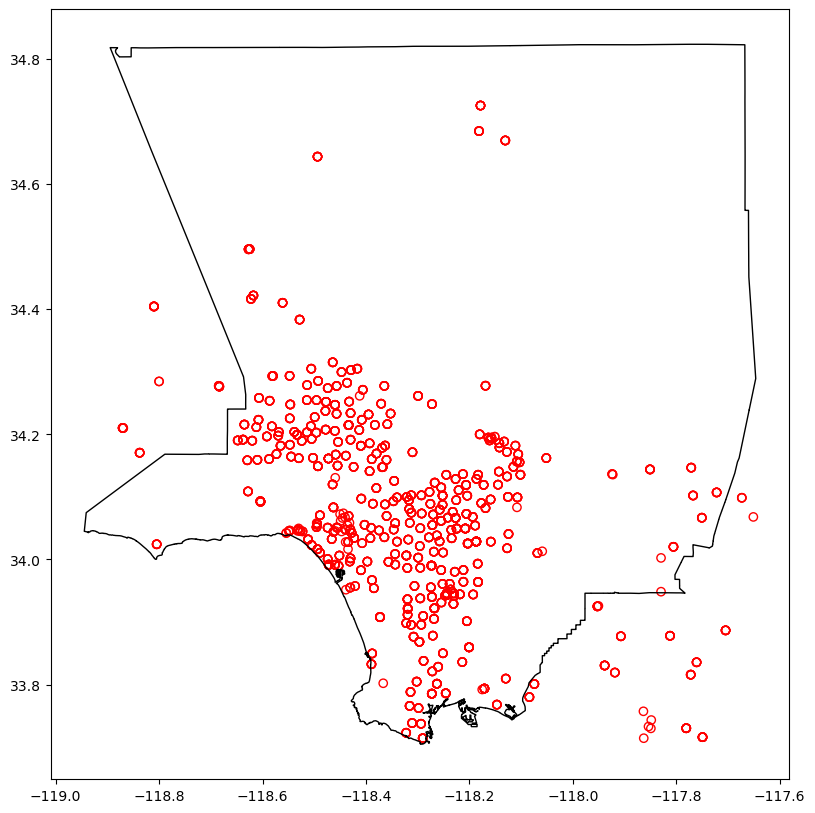

In [31]:
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');
stations_explode.plot(ax=ax, color='none', edgecolor='red');
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');

### Instruments

This is another nested feature:

In [32]:
stations_explode['instruments'][:2]

sensors_id
1502    [{'id': 2, 'name': 'Government Monitor'}]
1837    [{'id': 2, 'name': 'Government Monitor'}]
Name: instruments, dtype: object

In [33]:
list(stations_explode['instruments'])[0][0]['name']

'Government Monitor'

These are all the names of instrument types in the dataset:

In [34]:
set([list(stations_explode['instruments'])[i][0]['name'] for i in range(len(list(stations_explode['instruments'])))])

{'Aerosol Black Carbon Detector (ABCD)',
 'AirGradient ONE Generation 9 (I-9PSL-DE)',
 'AirGradient Open Air Generation 1 (O-1PST)',
 'Clarity Sensor',
 'Government Monitor',
 'N/A',
 'Unknown AirGradient Sensor'}

Each row now corresponds to one sensor and therefore one instrument, so I don't need to explode it again.

I will create new features for `instrument_id` and `instrument_name` on the off chance they become relevant:

In [35]:
stations_explode['instrument_name'] = [list(stations_explode['instruments'])[i][0]['name'] for i in range(len(list(stations_explode['instruments'])))]

In [36]:
stations_explode['instrument_id'] = [list(stations_explode['instruments'])[i][0]['id'] for i in range(len(list(stations_explode['instruments'])))]

In [37]:
stations_explode[['station_id','name','instrument_name','instrument_id']]

,station_id,name,instrument_name,instrument_id
sensors_id,,,,
1502,847,South Long Beach,Government Monitor,2
1837,1019,Pasadena,Government Monitor,2
1866,1036,Pico Rivera,Government Monitor,2
1876,1042,Piru - Pacific,Government Monitor,2
22301,1042,Piru - Pacific,Government Monitor,2
...,...,...,...,...
14628910,6129575,"La Verne, CA",AirGradient Open Air Generation 1 (O-1PST),24
14628911,6129575,"La Verne, CA",AirGradient Open Air Generation 1 (O-1PST),24
14628912,6129575,"La Verne, CA",AirGradient Open Air Generation 1 (O-1PST),24


I can now drop the old `instruments` feature so it's not nested anymore:

In [38]:
stations_explode.drop(columns=['instruments'],inplace=True)

### Oldest entries

The oldest data is from 2016

In [39]:
stations_explode.sort_values(by=['datetime_first.utc']).head()

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,bounds,country.id,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_last.local,geometry,instrument_name,instrument_id
sensors_id,,,,,,,,,,,,,,,,,,,,,
1502,847,PM2.5,South Long Beach,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,America/Los_Angeles,False,True,"[-118.175278, 33.792221, -118.175278, 33.792221]",155,...,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2022-05-05T15:00:00-07:00,POINT (-118.17528 33.79222),Government Monitor,2
8683,1575,SO₂,Los Angeles - N. Mai,2016-03-06 20:00:00+00:00,2017-06-07 21:00:00+00:00,America/Los_Angeles,False,True,"[-118.2417, 34.0669, -118.2417, 34.0669]",155,...,4,Unknown Governmental Organization,119,AirNow,34.066900,-118.241700,2017-06-07T14:00:00-07:00,POINT (-118.2417 34.0669),Government Monitor,2
2794,1585,O₃,Upland,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[-117.6733, 34.0986, -117.6733, 34.0986]",155,...,4,Unknown Governmental Organization,119,AirNow,34.098600,-117.673300,2016-11-09T13:00:00-08:00,POINT (-117.6733 34.0986),Government Monitor,2
2793,1585,PM10,Upland,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[-117.6733, 34.0986, -117.6733, 34.0986]",155,...,4,Unknown Governmental Organization,119,AirNow,34.098600,-117.673300,2016-11-09T13:00:00-08:00,POINT (-117.6733 34.0986),Government Monitor,2
2792,1585,PM2.5,Upland,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[-117.6733, 34.0986, -117.6733, 34.0986]",155,...,4,Unknown Governmental Organization,119,AirNow,34.098600,-117.673300,2016-11-09T13:00:00-08:00,POINT (-117.6733 34.0986),Government Monitor,2


In [40]:
len(stations_explode.sort_values(by=['datetime_first.utc']))

1966

The oldest `PM2.5` entries are also from 2016

In [41]:
stations_explode[stations_explode['pollutant'] == 'PM2.5'].sort_values(by=['datetime_first.utc']).head()

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,bounds,country.id,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_last.local,geometry,instrument_name,instrument_id
sensors_id,,,,,,,,,,,,,,,,,,,,,
1502,847,PM2.5,South Long Beach,2016-03-06 20:00:00+00:00,2022-05-05 22:00:00+00:00,America/Los_Angeles,False,True,"[-118.175278, 33.792221, -118.175278, 33.792221]",155,...,4,Unknown Governmental Organization,119,AirNow,33.792221,-118.175278,2022-05-05T15:00:00-07:00,POINT (-118.17528 33.79222),Government Monitor,2
22301,1042,PM2.5,Piru - Pacific,2016-03-06 20:00:00+00:00,2020-06-10 21:00:00+00:00,America/Los_Angeles,False,True,"[-118.81, 34.4044, -118.81, 34.4044]",155,...,4,Unknown Governmental Organization,119,AirNow,34.404400,-118.810000,2020-06-10T14:00:00-07:00,POINT (-118.81 34.4044),Government Monitor,2
2150,1200,PM2.5,Glendora - Laurel,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.85080000000002, 34.1439, -117.8508000000...",155,...,4,Unknown Governmental Organization,119,AirNow,34.143900,-117.850800,2025-12-09T17:00:00-08:00,POINT (-117.8508 34.1439),Government Monitor,2
2775,1575,PM2.5,Los Angeles - N. Mai,2016-03-06 20:00:00+00:00,2017-06-07 21:00:00+00:00,America/Los_Angeles,False,True,"[-118.2417, 34.0669, -118.2417, 34.0669]",155,...,4,Unknown Governmental Organization,119,AirNow,34.066900,-118.241700,2017-06-07T14:00:00-07:00,POINT (-118.2417 34.0669),Government Monitor,2
2792,1585,PM2.5,Upland,2016-03-06 20:00:00+00:00,2016-11-09 21:00:00+00:00,America/Los_Angeles,False,True,"[-117.6733, 34.0986, -117.6733, 34.0986]",155,...,4,Unknown Governmental Organization,119,AirNow,34.098600,-117.673300,2016-11-09T13:00:00-08:00,POINT (-117.6733 34.0986),Government Monitor,2


In [42]:
sensors_gdf = stations_explode

#### Complete coverage

In [43]:
len(stations_explode[stations_explode['pollutant'] == 'PM2.5'].sort_values(by=['datetime_first.utc']))

413

I want to map the distribution of stations which have a starting entry in 2016 and a most recent entry in the current year.

In [44]:
sensors_all_years_gdf = stations_explode[(stations_explode['datetime_first.utc'] > '2016') & (stations_explode['datetime_last.utc'] > str(dt.datetime.today().year))]

In [45]:
sensors_all_years_gdf.head()

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,bounds,country.id,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_last.local,geometry,instrument_name,instrument_id
sensors_id,,,,,,,,,,,,,,,,,,,,,
25500,1052,CO,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
4272146,1052,NO,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
25501,1052,NO₂,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
4272073,1052,NOx,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
1888,1052,O₃,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2


In [46]:
len(sensors_all_years_gdf)

1665

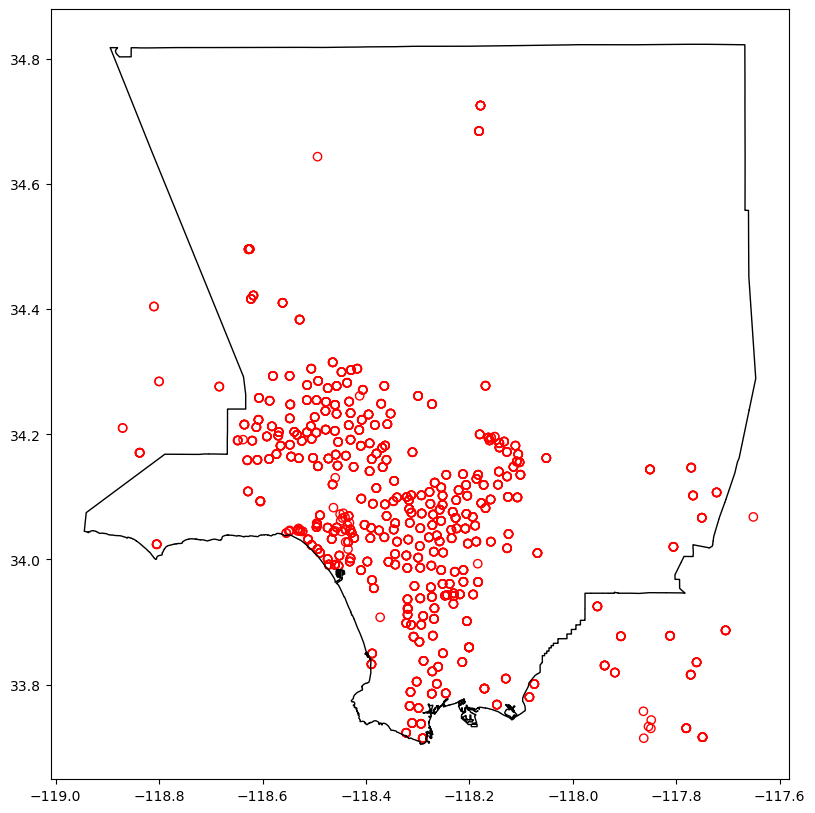

In [47]:
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');
sensors_all_years_gdf.plot(ax=ax, color='none', edgecolor='red');
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');

I will repeat this, but only looking at `PM2.5`

In [48]:
sensors_all_years_pm25_gdf = stations_explode[(stations_explode['pollutant'] == 'PM2.5') & (stations_explode['datetime_first.utc'] > '2016') & (stations_explode['datetime_last.utc'] > str(dt.datetime.today().year))]

In [49]:
sensors_all_years_pm25_gdf.head()

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,bounds,country.id,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_last.local,geometry,instrument_name,instrument_id
sensors_id,,,,,,,,,,,,,,,,,,,,,
2150,1200,PM2.5,Glendora - Laurel,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.85080000000002, 34.1439, -117.8508000000...",155,...,4,Unknown Governmental Organization,119,AirNow,34.143900,-117.850800,2025-12-09T17:00:00-08:00,POINT (-117.8508 34.1439),Government Monitor,2
25551,1948,PM2.5,Compton,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-118.205, 33.9014, -118.205, 33.9014]",155,...,4,Unknown Governmental Organization,119,AirNow,33.901400,-118.205000,2025-12-09T17:00:00-08:00,POINT (-118.205 33.9014),Government Monitor,2
3523,1989,PM2.5,Santa Clarita,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-118.52829999999999, 34.3833, -118.5282999999...",155,...,4,Unknown Governmental Organization,119,AirNow,34.383300,-118.528300,2025-12-09T17:00:00-08:00,POINT (-118.5283 34.3833),Government Monitor,2
3842,2138,PM2.5,Reseda,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-118.5331, 34.1992, -118.5331, 34.1992]",155,...,4,Unknown Governmental Organization,119,AirNow,34.199200,-118.533100,2025-12-09T17:00:00-08:00,POINT (-118.5331 34.1992),Government Monitor,2
15731,5791,PM2.5,710 Near Road,2016-11-15 21:00:00+00:00,2025-12-10 00:00:00+00:00,America/Los_Angeles,False,True,"[-118.20070700000001, 33.859662, -118.20070700...",155,...,4,Unknown Governmental Organization,119,AirNow,33.859662,-118.200707,2025-12-09T16:00:00-08:00,POINT (-118.20071 33.85966),Government Monitor,2


In [50]:
len(sensors_all_years_pm25_gdf)

341

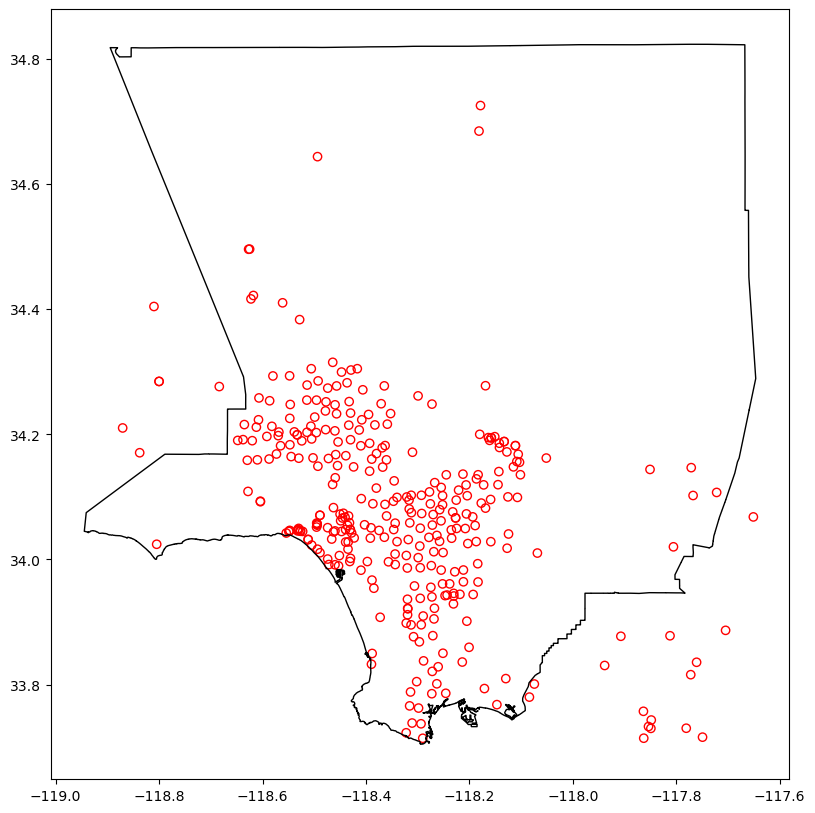

In [51]:
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');
sensors_all_years_pm25_gdf.plot(ax=ax, color='none', edgecolor='red');
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');

In [52]:
sensors_all_years_gdf.head()

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,bounds,country.id,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_last.local,geometry,instrument_name,instrument_id
sensors_id,,,,,,,,,,,,,,,,,,,,,
25500,1052,CO,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
4272146,1052,NO,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
25501,1052,NO₂,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
4272073,1052,NOx,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
1888,1052,O₃,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2


In [53]:
sensors_all_years_gdf.to_file(r"../../Data/Outputs/sensors_all_years.geojson",driver="GeoJSON")

### Visualizing spatial/temporal coverage by pollutant class

I want to plot the spatial coverage of sensors with complete temporal coverage (entries from 2016 to present) to see whether one pollutant class has uniquely good coverage across LA county

In [54]:
sensors_all_years_gdf.head(2)

,station_id,pollutant,name,datetime_first.utc,datetime_last.utc,timezone,is_mobile,is_monitor,bounds,country.id,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetime_last.local,geometry,instrument_name,instrument_id
sensors_id,,,,,,,,,,,,,,,,,,,,,
25500,1052,CO,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2
4272146,1052,NO,Pomona,2016-03-06 20:00:00+00:00,2025-12-10 01:00:00+00:00,America/Los_Angeles,False,True,"[-117.7506, 34.0667, -117.7506, 34.0667]",155,...,4,Unknown Governmental Organization,119,AirNow,34.0667,-117.7506,2025-12-09T17:00:00-08:00,POINT (-117.7506 34.0667),Government Monitor,2


In [55]:
pollutant_classes = sensors_all_years_gdf['pollutant'].unique()

In [56]:
pollutant_classes

array(['CO', 'NO', 'NO₂', 'NOx', 'O₃', 'PM10', 'PM2.5', 'SO₂', 'PM1',
       'Temperature (C)', 'Temperature (F)', 'RH', 'PM0.3 count'],
      dtype=object)

In [57]:
len(pollutant_classes)

13

https://matplotlib.org/stable/gallery/color/named_colors.html

https://xkcd.com/color/rgb/

In [58]:
len(list(mcolors.TABLEAU_COLORS))

10

In [59]:
int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))

0

In [60]:
list(mcolors.TABLEAU_COLORS)[int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))]

'tab:brown'

In [61]:
np.random.seed(42)
np.random.randint(0,2000)

1126

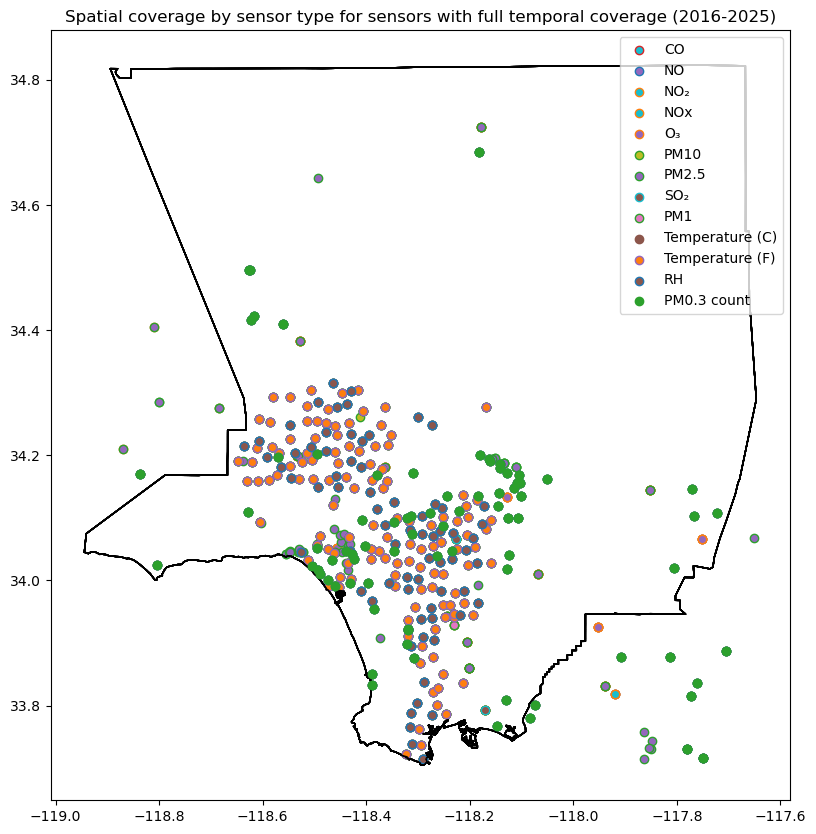

In [62]:
np.random.seed(6)
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');

for pollutant in list(pollutant_classes):
    la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
    sensors_all_years_gdf[sensors_all_years_gdf['pollutant'] == pollutant].plot(ax=ax, color=list(mcolors.TABLEAU_COLORS)[int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))], 
                                                                                edgecolor=list(mcolors.TABLEAU_COLORS)[int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))], 
                                                                                label=pollutant);
ax.set_title('Spatial coverage by sensor type for sensors with full temporal coverage (2016-2025)');
ax.legend();

This plot shows the spatial coverage of sensors which have oldest readings starting in 2016 and latest readings in 2025, divided by sensor type (pollutant class being measured). The plotted points will be overlapped, but it's been plotted sequentially, i.e. a `PM2.5` point indicates that no subsequent pollutant types: `SO2`, `PM1` . . . are present. I will plot this again in ArcGIS and get something easier to interpret.

In [63]:
sensors_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1966 entries, 1502 to 14679598
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   station_id             1966 non-null   int64              
 1   pollutant              1966 non-null   object             
 2   name                   1966 non-null   object             
 3   datetime_first.utc     1966 non-null   datetime64[ns, UTC]
 4   datetime_last.utc      1966 non-null   datetime64[ns, UTC]
 5   timezone               1966 non-null   object             
 6   is_mobile              1966 non-null   bool               
 7   is_monitor             1966 non-null   bool               
 8   bounds                 1966 non-null   object             
 9   country.id             1966 non-null   int64              
 10  country.code           1966 non-null   object             
 11  country.name           1966 non-null   object 

In [65]:
sensors_gdf.to_file("../../Data/Outputs/sensors_gdf.geojson", driver="GeoJSON")

In [64]:
1/0

ZeroDivisionError: division by zero

In [ ]:
sensors_gdf['datetime_last.utc'] = pd.to_datetime(sensors_gdf['datetime_last.utc'])

In [ ]:
sensors_gdf.info()

In [ ]:
sensors_gdf['pollutant'] = [sensors_gdf.iloc[i]['sensors']['parameter']['display_name'] for i in range(len(sensors_gdf))]

In [ ]:
sensors_gdf['sensor_id'] = [sensors_gdf.iloc[i]['sensors']['id'] for i in range(len(sensors_gdf))]

In [ ]:
sensors_gdf.drop(columns=['sensors'],inplace=True)

In [ ]:
sensors_gdf.info()

In [ ]:
sensors_gdf = sensors_gdf.sort_values(by='datetime_last.utc')

In [ ]:
sensors_gdf.head()

In [ ]:
sensors_gdf[(sensors_gdf['pollutant'] == 'PM2.5') & (sensors_gdf['datetime_last.utc'] > '2025-01-01')]

https://docs.python.org/3/library/datetime.html#datetime.datetime.now

In [ ]:
today = dt.datetime.now(dt.timezone.utc)

In [ ]:
one_week_ago = today - dt.timedelta(weeks=1)

In [ ]:
active_pm2_5 = sensors_gdf[(sensors_gdf['pollutant'] == 'PM2.5') & (sensors_gdf['datetime_last.utc'] > one_week_ago)]

In [ ]:
active_pm2_5 = active_pm2_5.sort_values(by='datetime_last.utc')

In [ ]:
active_pm2_5.head()

In [ ]:
sensors_gdf[sensors_gdf['id'] == 3778909]

In [ ]:
active_pm2_5[active_pm2_5['sensor_id'] == 14152560]

In [ ]:
active_pm2_5[active_pm2_5['id'] == 3778909]

In [ ]:
active_pm2_5.info()

The `id` column can now be passed in to an Athena query

In [ ]:
station_IDs = list(active_pm2_5['id'])

In [ ]:
station_IDs[:10]

In [ ]:
sensor_IDs = list(active_pm2_5['sensor_id'])
print(sensor_IDs[:5])

In [ ]:
1/0

## Athena

In [ ]:
cursor = connect(
    s3_staging_dir="s3://la-openaq-athena-results-us-east-1/temp/",
    region_name="us-east-1"
).cursor()

cursor.execute("DROP TABLE openaq_db.openaqMeasurements;")

In [ ]:
create_table = """
CREATE EXTERNAL TABLE IF NOT EXISTS openaq_db.openaqMeasurements (
  location_id INT,
  sensors_id INT,
  location STRING,
  datetime STRING,
  lat DOUBLE,
  lon DOUBLE,
  parameter STRING,
  units STRING,
  value DOUBLE
)
PARTITIONED BY (locationid STRING, year STRING, month STRING)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES ('serialization.format'=',','field.delim'=',')
LOCATION 's3://openaq-data-archive/records/csv.gz/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""
cursor.execute(create_table)

month is handled as `str(today.month).zfill(2)` to ensure March -> 04

In [ ]:
for location in station_IDs:
    cursor.execute(f"""
    ALTER TABLE openaq_db.openaqMeasurements ADD
    PARTITION (year='{today.year}', month='{str(today.month).zfill(2)}', locationid='{location}')
    LOCATION 's3://openaq-data-archive/records/csv.gz/locationid={location}/year={today.year}/month={str(today.month).zfill(2)}/';
    """)

In [ ]:
cursor.execute(f"""
SELECT *
FROM (
    SELECT *,
           ROW_NUMBER() OVER (
               PARTITION BY sensors_id
               ORDER BY datetime DESC
           ) AS rn
    FROM openaq_db.openaqMeasurements
    WHERE year = '{today.year}'
      AND month = '{str(today.month).zfill(2)}'
      AND sensors_id IN {tuple(sensor_IDs)}
) sub
WHERE rn = 1
ORDER BY datetime DESC;
"""
)
records = cursor.fetchall()

In [ ]:
records[3]

In [ ]:
la_df = pd.DataFrame(data = records, columns=[
    "location_id", "sensors_id", "location", "datetime",
    "lat", "lon", "parameter", "units", "value",
    "partition_locationid", "year", "month", "day"
])
la_gdf = gpd.GeoDataFrame(
    la_df,
    geometry=[Point(xy) for xy in zip(la_df.lon, la_df.lat)],
    crs="EPSG:4326"
)


In [ ]:
la_gdf.head()

In [ ]:
la_gdf['datetime_utc'] = pd.to_datetime(la_gdf['datetime'])

In [ ]:
la_gdf.drop(columns=['partition_locationid','year','month','day','datetime','lat','lon'],inplace=True)

In [ ]:
la_gdf.info()

In [ ]:
la_gdf.columns[:-2]

In [ ]:
la_gdf.head()

In [ ]:
gdf.to_file('../Data/Outputs/la_gdf.gpkg', driver='GPKG', layer='outliers_la_gdf')

In [ ]:
la_gdf = gpd.read_file("../Data/Outputs/la_gdf.gpkg", layer='la_gdf')

In [ ]:
la_gdf['value'].mean()

Physically, it is impossible for us to have a valid reading with `>1000 µg/m³`. Regardless, we can use the inter-quartile range of the data, and clip anything beyond 1.5x of this middle 50%.

In [ ]:
la_gdf['value'].sort_values()

In [ ]:
Q1 = la_gdf['value'].quantile(0.25)
Q3 = la_gdf['value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

la_gdf_filtered = la_gdf[
    (la_gdf['value'] >= lower_bound) &
    (la_gdf['value'] <= upper_bound)
]


In [ ]:
la_gdf_filtered['value'].sort_values()

In [ ]:
la_gdf_filtered.to_file('../Data/Outputs/la_gdf.gpkg', driver='GPKG', layer='la_gdf_filtered')

In [ ]:
np.random.seed(3)
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');

for pollutant in list(pollutant_classes):
    la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
    sensors_all_years_gdf[sensors_all_years_gdf['pollutant'] == pollutant].plot(ax=ax, color=list(mcolors.TABLEAU_COLORS)[int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))], 
                                                                                edgecolor=list(mcolors.TABLEAU_COLORS)[int(np.random.randint(0,len(list(mcolors.TABLEAU_COLORS))))], 
                                                                                label=pollutant);
ax.set_title('Spatial coverage by sensor type for sensors with full temporal coverage (2016-2025)');
ax.legend();